In [1]:
import sys
import numpy as np
import sacc
import yaml
import pacc
import pandas as pd
import firecrown

import firecrown.likelihood.weak_lensing as wl
import firecrown.likelihood.number_counts as nc
from firecrown.likelihood.two_point import TwoPoint
from firecrown.likelihood.gaussian import ConstGaussian

In [2]:
from firecrown.metadata.two_point import extract_all_data_types_xi_thetas
s = sacc.Sacc.load_fits("examples/des_y1_3x2pt/des_y1_3x2pt_sacc_data.fits")


In [3]:
cle = pacc.ClsEnsemble(s, label="DES Y1 real space")

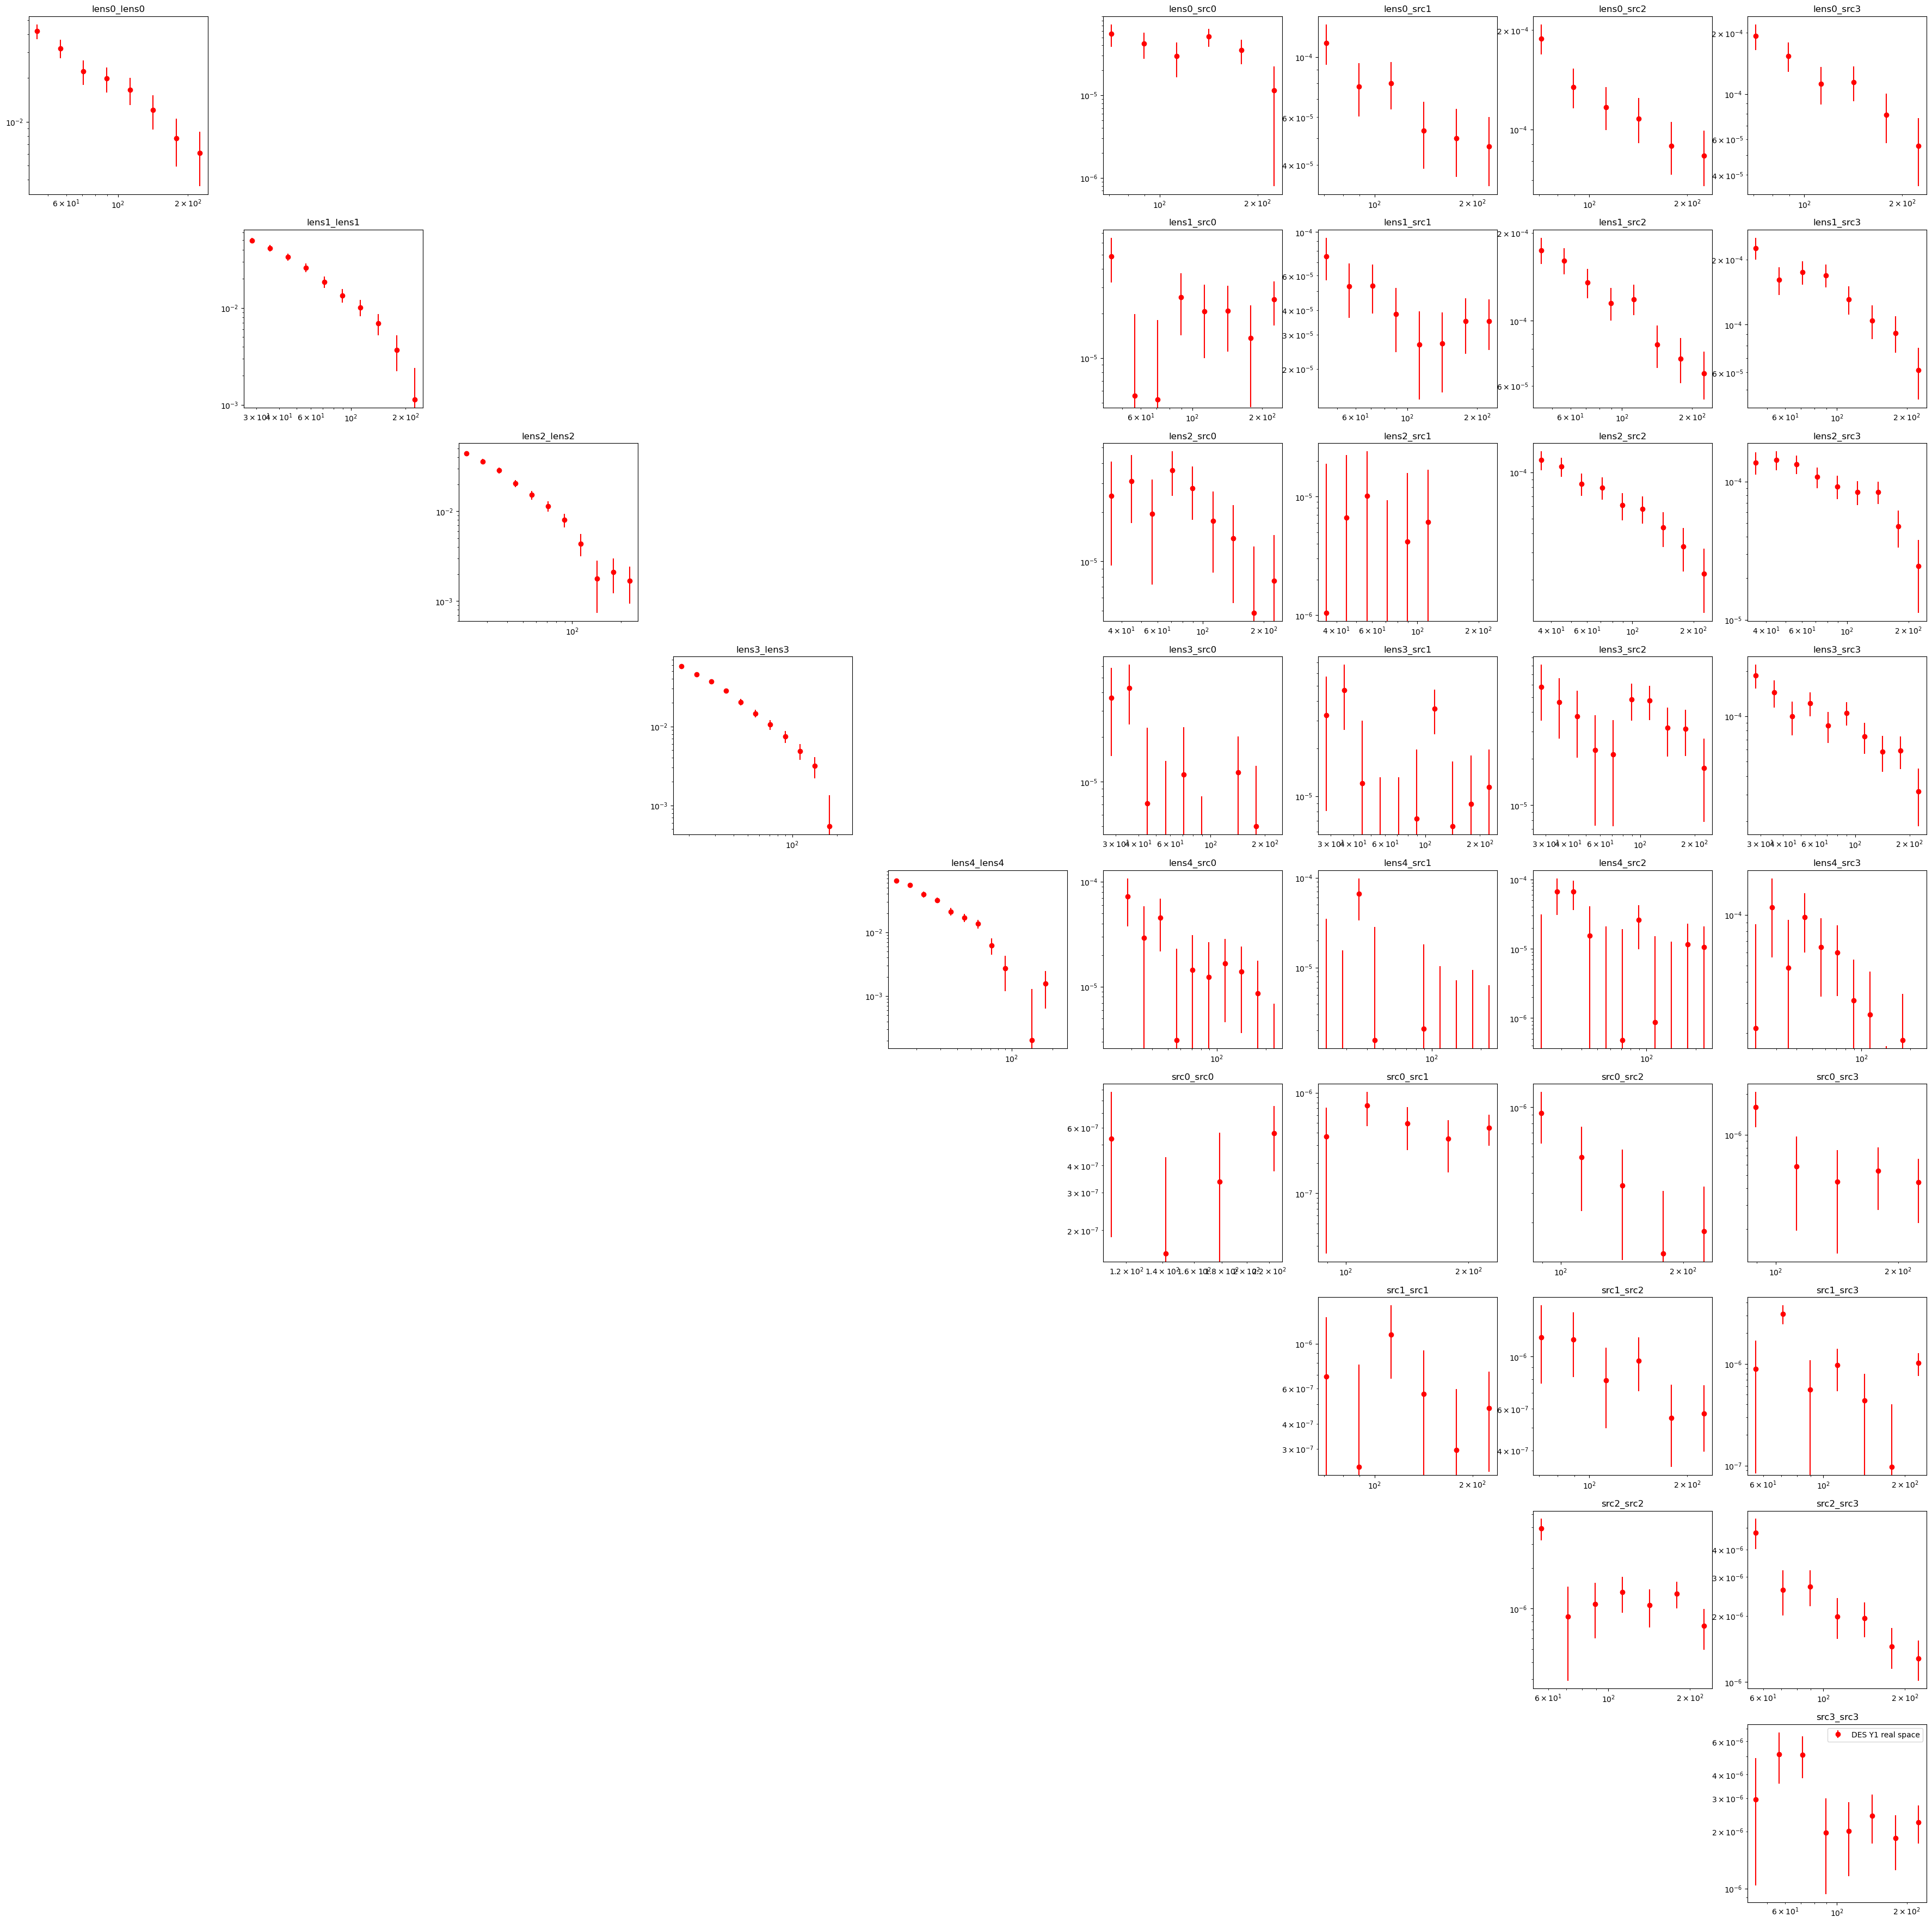

In [4]:
pacc.plot_cls([cle], cle.pairs)

In [5]:
from firecrown.likelihood.two_point import TwoPoint
from firecrown.likelihood.weak_lensing import WeakLensingFactory
from firecrown.likelihood.number_counts import NumberCountsFactory
from firecrown.utils import base_model_from_yaml

all_meta = extract_all_data_types_xi_thetas(s)

# WeakLensing systematics -- global
ia_systematic = wl.LinearAlignmentSystematicFactory()
# WeakLensing systematics -- per-bin
wl_photoz = wl.PhotoZShiftFactory()
wl_mult_bias = wl.MultiplicativeShearBiasFactory()

# NumberCounts systematics -- global
# As for Firecrown 1.8.0a0, we do not have any global systematics for number counts
# NumberCounts systematics -- per-bin
nc_photoz = nc.PhotoZShiftFactory()

wlf = wl.WeakLensingFactory(
    per_bin_systematics=[wl_mult_bias, wl_photoz],
    global_systematics=[ia_systematic],
)
ncf = nc.NumberCountsFactory(
    per_bin_systematics=[nc_photoz],
    global_systematics=[],
)

two_point_list = TwoPoint.from_metadata_only_real(
    metadata=all_meta, wl_factory=wlf, nc_factory=ncf)

In [8]:
import pyccl
from firecrown.modeling_tools import ModelingTools
from firecrown.likelihood.gaussian import ConstGaussian
from firecrown.parameters import ParamsMap

likelihood = ConstGaussian(two_point_list)
likelihood.read(s)
req_params = likelihood.required_parameters()
default_values = req_params.get_default_values()
params = ParamsMap(default_values)
likelihood.update(params)

ccl_cosmo = pyccl.CosmologyVanillaLCDM()
ccl_cosmo.compute_nonlin_power()
tools = ModelingTools()
tools.update(params)
tools.prepare(ccl_cosmo)

In [10]:
theory= []
for tp in two_point_list:
    theory.append(np.array(tp.compute_theory_vector(tools)))
theory = np.concatenate(theory)

t_cle = pacc.ClTheoryEnsemble(cle, theory, label="DES Y1 real space")

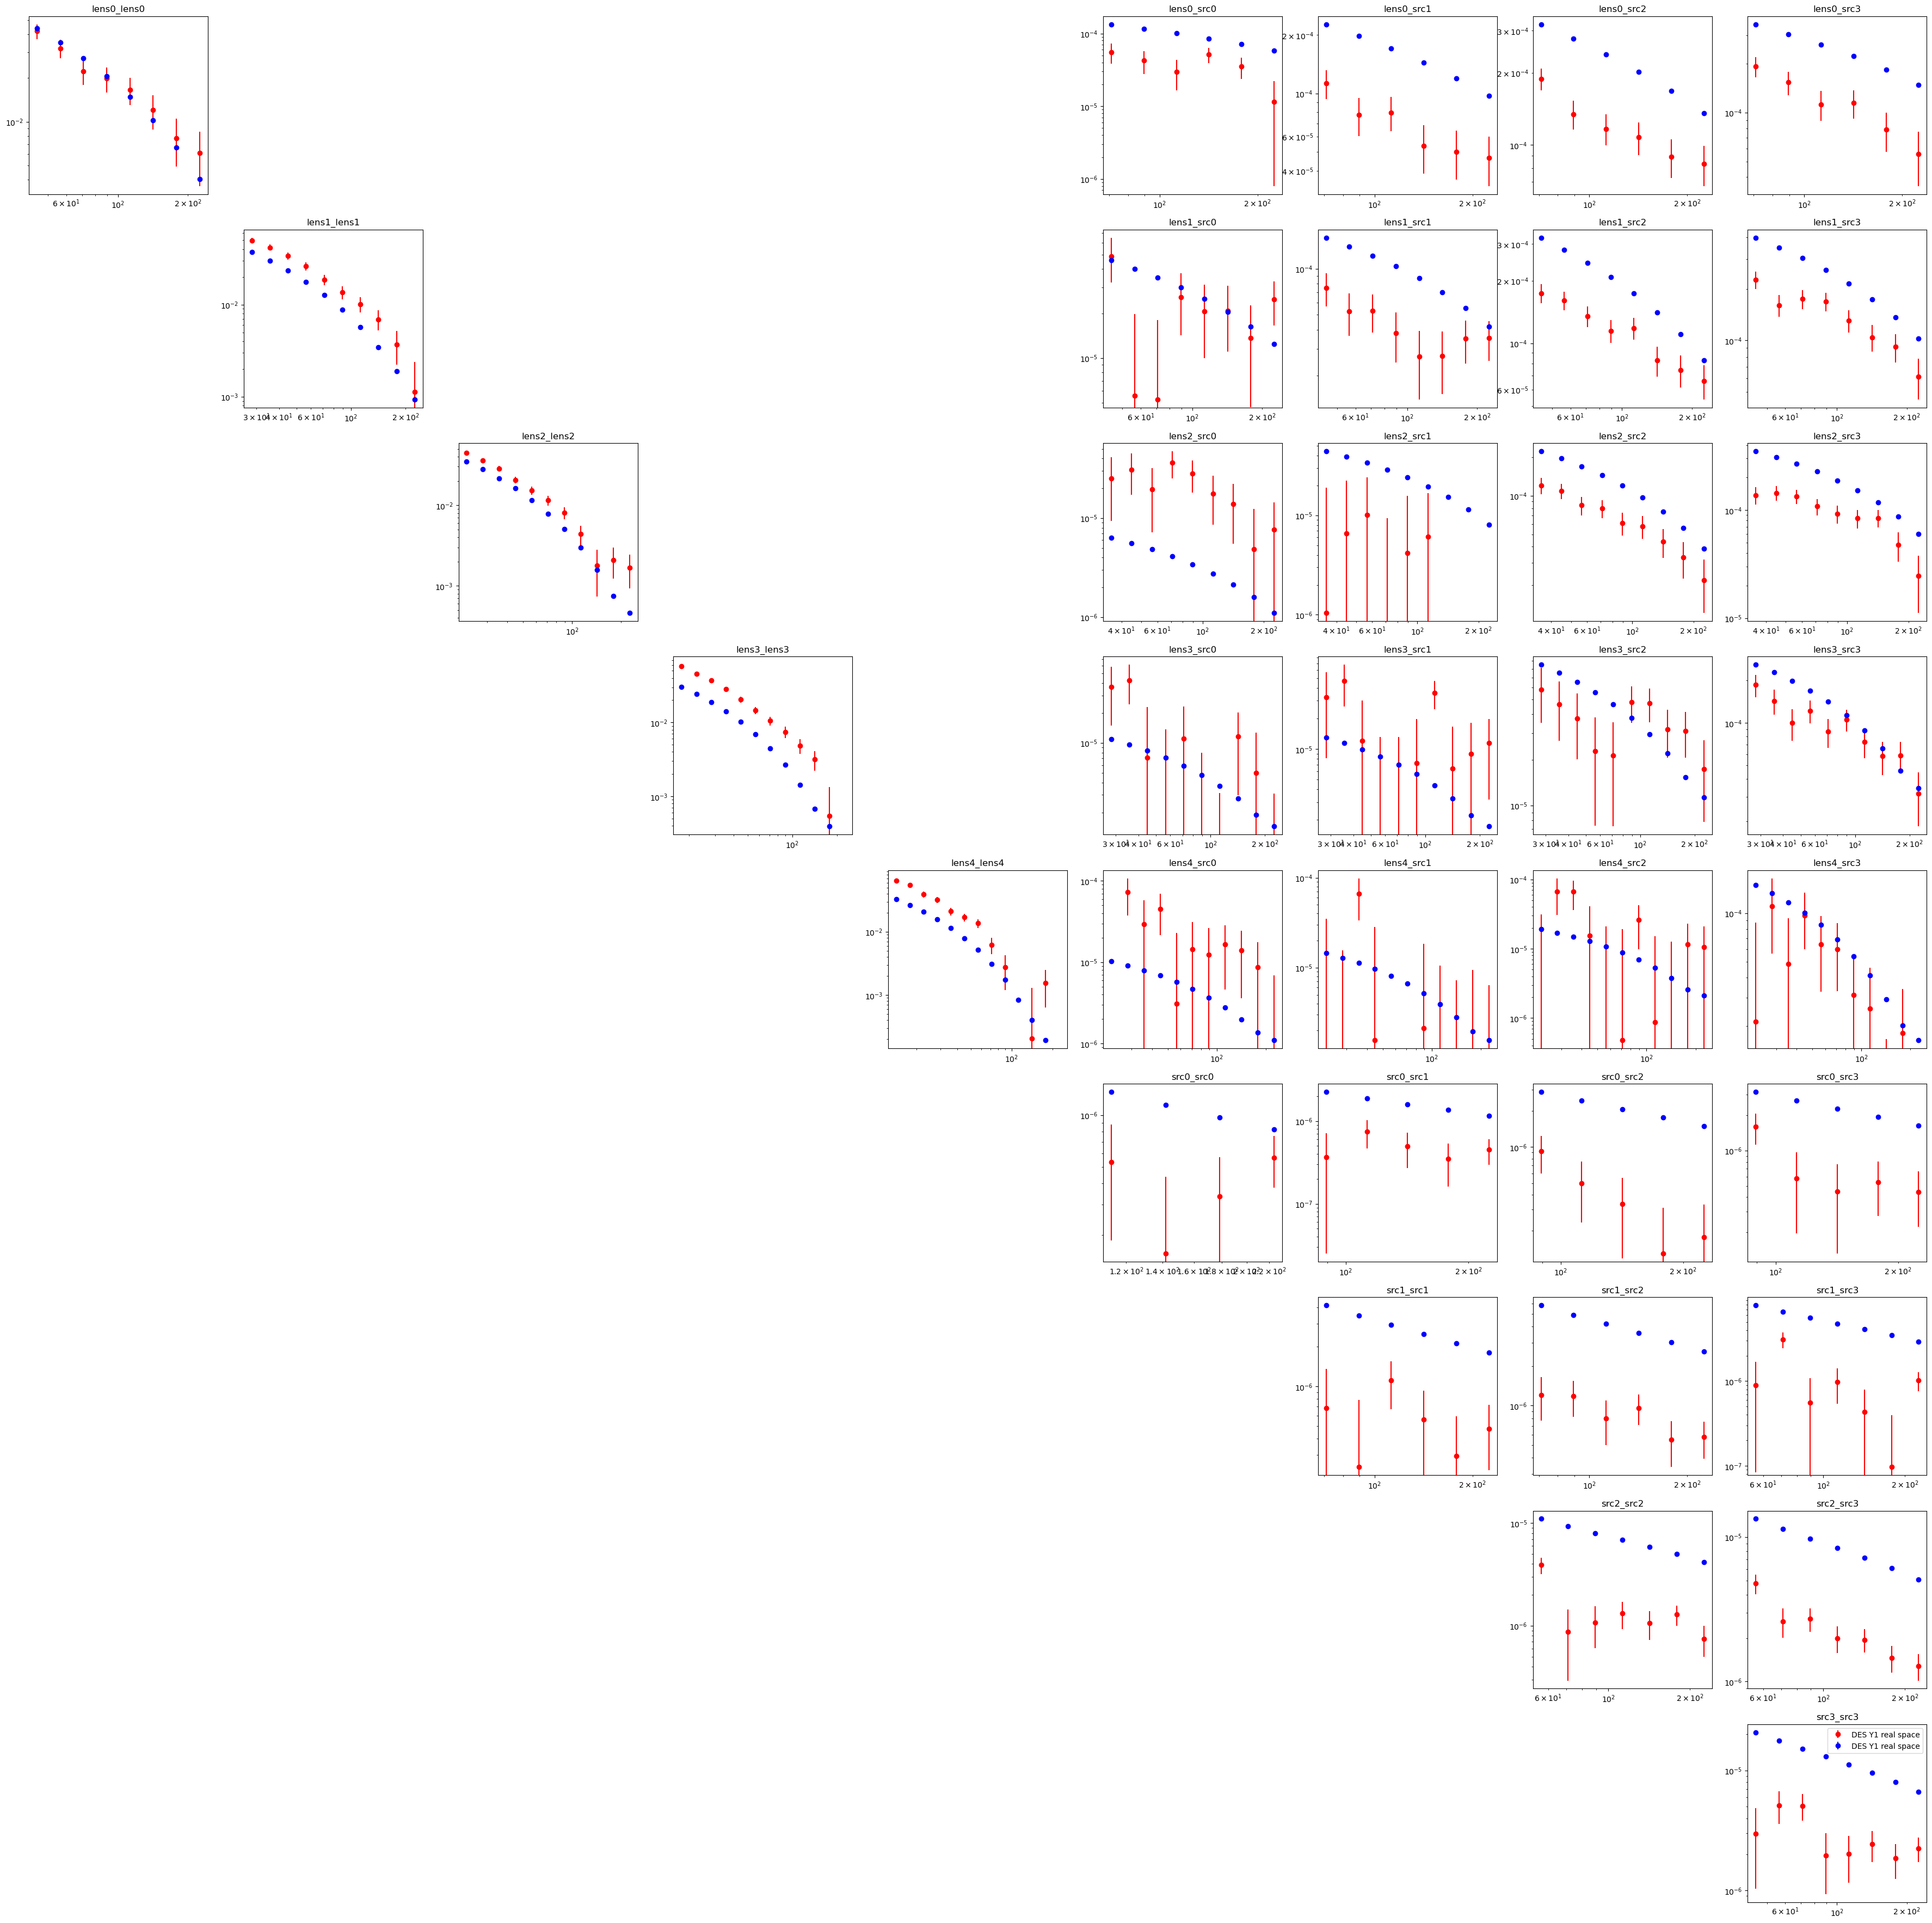

In [11]:
pacc.plot_cls([cle, t_cle], cle.pairs)